# SOLUTION 1: Try to define quantifiers 

In [10]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy
from skimage.filters import threshold_otsu,sobel,sobel_v,sobel_h 
from scipy import ndimage
import os
from os import listdir
from os.path import isfile, join
from PIL import Image
from scipy import io
dirname = os.getcwd()
dirname = os.path.join(dirname,'..','data','duke2D')
path_normal = os.path.join(dirname,'normal')

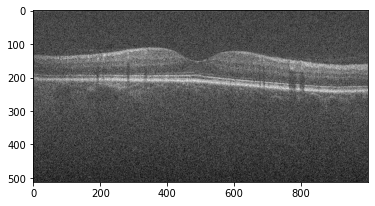

In [15]:
files = [f for f in listdir(path_normal) if isfile(join(path_normal, f))]
image_name = files[0]
image = mpimg.imread(os.path.join(path_normal,image_name))
plt.imshow(image,cmap="gray")